In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

# Analysis
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

## Read in data

In [3]:
## Ran 2017 with more patch-level output to more directly compare with LST data 

saveDir = '/glade/scratch/mdfowler/CLASP_ensOutput/morePatchOutput/'

listFiles_clmh1 = np.sort(glob.glob(saveDir+'*clm2.h1*'))
listFiles_clmh0 = np.sort(glob.glob(saveDir+'*clm2.h0*'))
listFiles_camh1 = np.sort(glob.glob(saveDir+'*cam.h1*'))

for iFile in range(len(listFiles_clmh1)):
    with xr.open_dataset(listFiles_camh1[iFile], decode_times=False) as camDS: 
        camDS         = cesm_correct_time(camDS)
        camDS['time'] = camDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(listFiles_clmh1[iFile], decode_times=False) as clmPatchDS: 
        clmPatchDS['time'] = camDS['time'] 
    
    with xr.open_dataset(listFiles_clmh1[iFile], decode_times=False) as clmGridDS: 
        clmGridDS['time'] = camDS['time'] 
    
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (camDS.time.values >= (camDS.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (camDS.time.values <= (camDS.time.values[0] + np.timedelta64(2,'D'))))[0]

    camDS      = camDS.isel(time=iTimeStart_day2)
    clmPatchDS = clmPatchDS.isel(time=iTimeStart_day2)
    clmGridDS  = clmGridDS.isel(time=iTimeStart_day2)

    if iFile==0:
        htgCAM_allDays   = camDS
        htgCLMg_allDays  = clmGridDS
        htgCLMp_allDays  = clmPatchDS
    else:
        htgCAM_allDays   = xr.concat([htgCAM_allDays,  camDS],  dim='time')
        htgCLMg_allDays  = xr.concat([htgCLMg_allDays,  clmGridDS],  dim='time')
        htgCLMp_allDays  = xr.concat([htgCLMp_allDays,  clmPatchDS],  dim='time')
        
print('Done reading in 2017 days')
    

Done reading in 2017 days


In [5]:
# # Add month_day index to arrays

# month_day_day2                     = pd.MultiIndex.from_arrays([day2_upsample['time.year'].values,
#                                                                 day2_upsample['time.month'].values, 
#                                                                 day2_upsample['time.day'].values])
# day2_upsample.coords['year_month_day']     = ('time', month_day_day2)
# day2_upsampleCLM.coords['year_month_day']  = ('time', month_day_day2)



In [4]:
# Get the lat/lon associated with SCAM site 

iopLAT = htgCAM_allDays.lat.values
iopLON = np.mod((htgCAM_allDays.lon.values+180),360)-180
print('SCAM location (lat,lon): ', iopLAT, iopLON)

SCAM location (lat,lon):  [36.61000061] [-97.48999786]


In [5]:
# Resample to hourly 

htgCAM_allDays_hourly  = htgCAM_allDays.resample(time="1H").mean()
htgCLMp_allDays_hourly = htgCLMp_allDays.resample(time="1H").mean()
htgCLMg_allDays_hourly = htgCLMg_allDays.resample(time="1H").mean()


In [6]:
## Compute TG variance? 

# Weight of each PFT over the gridcell (doesn't change in time here)
COLwgt = htgCLMp_allDays_hourly.cols1d_wtgcell.values[0,:]
# PFT types 
PFTtype = htgCLMp_allDays_hourly.pfts1d_itype_veg.values[0,:]
# Column types 
colType = htgCLMp_allDays_hourly.pfts1d_itype_col.values[0,:]

## Now get variance over the gridcell, but needs to be weighted... so use same scheme as in CLM module 

# Need gridcell mean 
wgtGridMean_TG_HTG = (np.sum(htgCLMp_allDays_hourly['TG'].values*COLwgt,axis=1)/np.sum(COLwgt))

# Now get each patch's difference from that gridcell mean 
varUnweighted_TG_HTG = np.full([len(htgCLMp_allDays_hourly.time.values), len(COLwgt)], np.nan)

for iPatch in range(len(COLwgt)):
    varUnweighted_TG_HTG[:,iPatch] = (htgCLMp_allDays_hourly['TG'].values[:,iPatch] - wgtGridMean_TG_HTG)**2
    
# Now get the weighted mean of that across the gridcell
wgtVarianceTG_HTG = (np.sum(varUnweighted_TG_HTG*COLwgt,axis=1)/np.sum(COLwgt))



In [8]:
# plt.plot(day2_upsampleCLMhourly.time.values, day2_upsampleCLMhourly.sel(case='HMG').TG.values, label='TG_clm')
# plt.plot(day2_upsamplehourly.time.values,    np.squeeze(day2_upsamplehourly.sel(case='HMG').TS.values), label='TS_cam')
# plt.plot(day2_upsampleCLMhourly.time.values, day2_upsampleCLMhourly.sel(case='HMG').TSA.values, label='TSA_clm')
# plt.legend()

# plt.xlim([datetime.date(2017,7,1), datetime.date(2017,8,1) ])


## Grab LST data

In [3]:
saveDir = '/glade/work/mdfowler/CLASP/LST_obs_fromLaura/'

testCOPERNICUSfn = saveDir+'COPERNICUS_LST_stats_2017.nc'
testGOESfn25     = saveDir+'GOES/GOES_LST_stats_0.25x0.25.nc'
testGOESfn1      = saveDir+'GOES/GOES_LST_stats_1x1.nc'

cprnDS   = xr.open_dataset(testCOPERNICUSfn, decode_times=False)
goesDS25 = xr.open_dataset(testGOESfn25,     decode_times=True)
goesDS1  = xr.open_dataset(testGOESfn1,      decode_times=True)


In [4]:
startTime = datetime.datetime(2017,1,1, 0,0,0)
nHours = 0 

for iT in range(len(cprnDS.time.values)):
    addStep  = startTime+timedelta(hours=nHours)
    
    if iT==0:
        cprnTime = addStep
    else:
        cprnTime = np.append(cprnTime, addStep)
        
    nHours = nHours+1

## Assign useful time index
cprnDS['datetime'] = (('time'), cprnTime)
cprnDS             = cprnDS.set_index(time='datetime')

In [6]:
goesDS1.lat.values[2]-goesDS1.lat.values[1]

-0.9880024196222621

In [8]:
cprnDS.time.values

array(['2017-01-01T00:00:00.000000000', '2017-01-01T01:00:00.000000000',
       '2017-01-01T02:00:00.000000000', ...,
       '2017-12-31T21:00:00.000000000', '2017-12-31T22:00:00.000000000',
       '2017-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [9]:
cprnDS = cprnDS.sel(lat=iopLAT, lon=iopLON, method='nearest').isel(time=np.where( (cprnDS['time.year'].values>=2017)  & 
                                                                                  (cprnDS['time.year'].values<=2018) )[0])
goesDS1 = goesDS1.sel(lat=iopLAT, lon=iopLON, method='nearest').isel(time=np.where( (goesDS1['time.year'].values>=2017)  & 
                                                                                    (goesDS1['time.year'].values<=2018) )[0])
goesDS25 = goesDS25.sel(lat=iopLAT, lon=iopLON, method='nearest').isel(time=np.where( (goesDS25['time.year'].values>=2017)  & 
                                                                                     (goesDS25['time.year'].values<=2018) )[0])


In [10]:
## Mask missing data
mask = np.where(goesDS1['std'].values == -9999)[0]
goesDS1['std'].values[mask] = np.nan

mask2 = np.where(goesDS25['std'].values == -9999)[0]
goesDS25['std'].values[mask2] = np.nan


Text(0, 0.5, 'K^2')

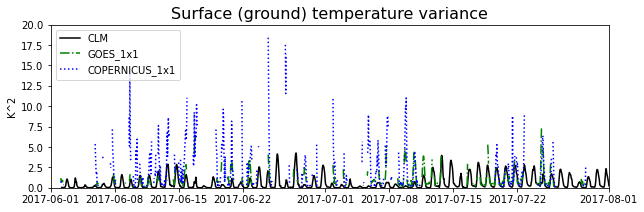

In [53]:
fig,axs = plt.subplots(1,1, figsize=(10,3))

axs.plot( htgCLMp_allDays_hourly.time.values, wgtVarianceTG_HTG,    'k-',label='CLM')
axs.plot(goesDS1.time.values, np.squeeze(goesDS1['std'].values**2), 'g-.',label='GOES_1x1' )
axs.plot(cprnDS.time.values, np.squeeze(cprnDS['std'].values**2),   'b:',label='COPERNICUS_1x1' )
axs.legend()

axs.set_xlim([datetime.date(2017,6,1), datetime.date(2017,8,1)])
axs.set_ylim([0,20])
axs.set_title('Surface (ground) temperature variance',fontsize=16)
axs.set_ylabel('K^2')

(17318.0, 17379.0)

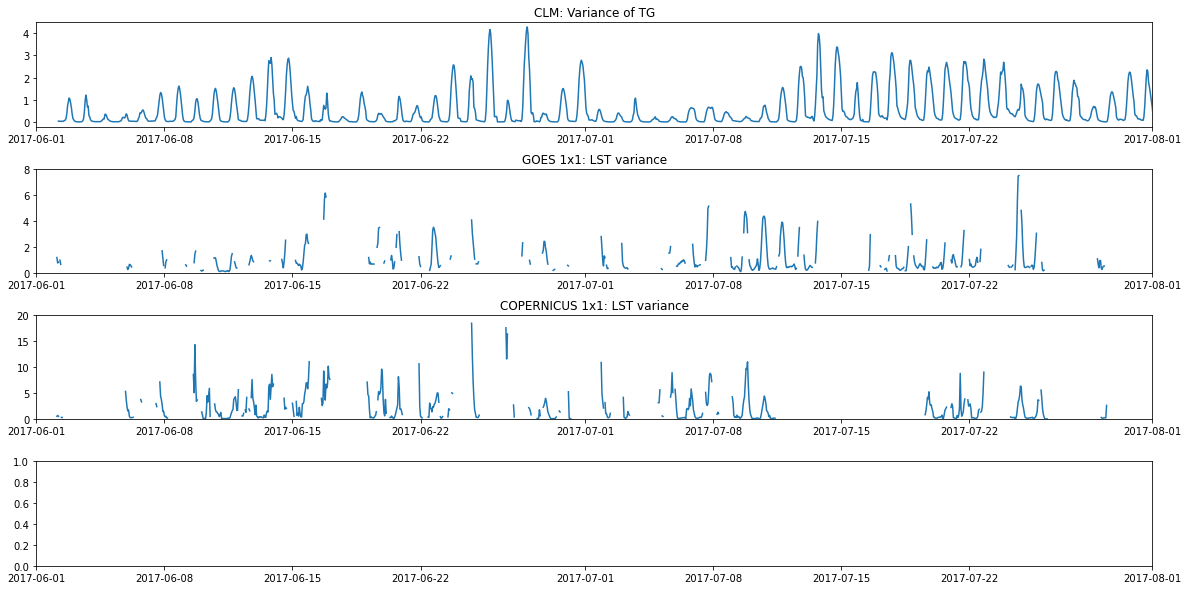

In [41]:
fig,axs = plt.subplots(4,1, figsize=(20,10))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.4)

axs[0].plot( htgCLMp_allDays_hourly.time.values, wgtVarianceTG_HTG)
             # np.squeeze(day2_upsamplehourly.sel(case='HTG*01').isel(ilev=-1).THLP2_CLUBB.values) - 
             # np.squeeze(day2_upsamplehourly.sel(case='HMG').isel(ilev=-1).THLP2_CLUBB.values))
axs[0].set_title('CLM: Variance of TG')
# axs[0].set_ylim([0, 0.5])


axs[1].plot(goesDS1.time.values, np.squeeze(goesDS1['std'].values**2), '-' )
axs[1].set_title('GOES 1x1: LST variance')
axs[1].set_ylim([0,8])

axs[2].plot(cprnDS.time.values, np.squeeze(cprnDS['std'].values**2), '-' )
axs[2].set_title('COPERNICUS 1x1: LST variance')
axs[2].set_ylim([0,20])

# axs[3].plot(goesDS25.time.values, np.squeeze(goesDS25['std'].values**2), '-' )
# axs[3].set_title('GOES 0.25x0.25: LST variance')
# axs[3].set_ylim([0,5])

axs[0].set_xlim([datetime.date(2017,6,1), datetime.date(2017,8,1)])
axs[1].set_xlim([datetime.date(2017,6,1), datetime.date(2017,8,1)])
axs[2].set_xlim([datetime.date(2017,6,1), datetime.date(2017,8,1)])
axs[3].set_xlim([datetime.date(2017,6,1), datetime.date(2017,8,1)])


Text(0.5, 1.0, 'GOES (1x1): LST variance')

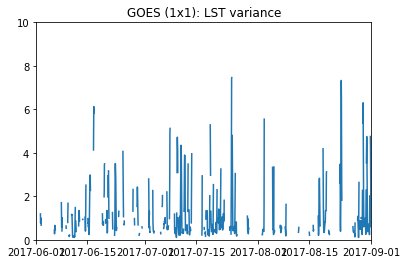

In [53]:
plt.plot(goesDS1.time.values, np.squeeze(goesDS1['std'].values**2), '-' )
plt.xlim([datetime.date(2017,6,1), datetime.date(2017,9,1)])
plt.ylim([0,10])
plt.title('GOES (1x1): LST variance')

(0.0, 100000.0)

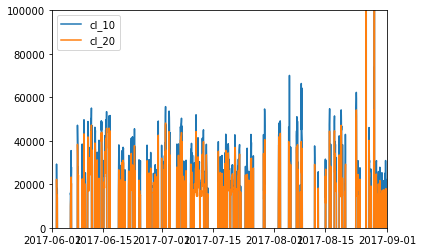

In [10]:
plt.plot(goesDS1.time.values, np.squeeze(goesDS1['cl_10'].values), label='cl_10' )
# plt.plot(goesDS1.time.values, np.squeeze(goesDS1['cl_15'].values), label='cl_15' )
plt.plot(goesDS1.time.values, np.squeeze(goesDS1['cl_20'].values), label='cl_20' )
plt.legend()
plt.xlim([datetime.date(2017,6,1), datetime.date(2017,9,1)])
plt.ylim([0,1e5])

<xarray.Dataset>
Dimensions:  (lat: 1, lon: 1, time: 8784)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:00:00
  * lat      (lat) float64 36.5
  * lon      (lon) float64 -97.5
Data variables:
    cl_10    (time, lat, lon) float32 ...
    cl_15    (time, lat, lon) float32 ...
    cl_20    (time, lat, lon) float32 ...
    std      (time, lat, lon) float32 nan nan nan ... 0.007934 0.008227 0.009326
    mean     (time, lat, lon) float32 ...
    p25      (time, lat, lon) float32 ...
    p50      (time, lat, lon) float32 ...
    p75      (time, lat, lon) float32 ...

In [15]:
goesDS1

<xarray.Dataset>
Dimensions:  (lat: 1, lon: 1, time: 14088)
Coordinates:
  * time     (time) datetime64[ns] 2017-05-24 ... 2018-12-31T23:00:00
  * lat      (lat) float64 36.78
  * lon      (lon) float64 -97.95
Data variables:
    std      (time, lat, lon) float32 nan nan nan 0.7417 ... nan nan nan nan
    mean     (time, lat, lon) float32 ...
    cl_5     (time, lat, lon) float32 ...
    cl_10    (time, lat, lon) float32 ...
    cl_15    (time, lat, lon) float32 ...
    cl_20    (time, lat, lon) float32 ...
    p25      (time, lat, lon) float32 ...
    p50      (time, lat, lon) float32 ...
    p75      (time, lat, lon) float32 ...